# Part 2
## Double Deep Q-learning

As before with the tabular Q-learning (part 1 of this tutorial), Double Deep Q-learning seeks to learn the "quality" function $Q(s,a)$. The difference in this case is that instead of using a table to store all the values of $Q(s,a)$, we are going to use a Neural Network to approximate the unknown function $Q(s,a)$.

# Understanding Neural Networks

Before we dive into the details of how Double Deep Q-learning works, let us first gain some intuition on how Neural Networks work.

### A single neuron neural network

<img src="https://raw.githubusercontent.com/jpmartinez10/RL-tutorial/master/numpy-based/imgs/nn_v1.png">

Neural networks can be seen as differentiable graphs where information can flow in two ways: forward way and backward way. For instance, consider the one neuron neural network shown in the figure. Here, the information flowing in the forward way is shown in color blue, and the information flowing in the backward way is shown in color red (the black arrows indicate the direction of the forward way).

The forward way, or forward pass, is used to perform a series of math operations on the flowing information. This math operations are determined by the structure of the network (i.e. the connections, the activation functions, etc.) and the parameters of the network (i.e. weights and biases). On the other hand, the backward way, or backward pass, is used to distribute gradients of errors that will be used to update the parameters of the network, and hence, train the network to approximate a desired unknown function.

The process of training a neural network can be summarized in the following steps:
* 1. Feedforward an input of data (forward pass).
* 2. Compute a loss between the network's output and the desired output.
* 3. Backpropagate the gradient of the loss w.r.t each of the parameters of the network (backward pass).
* 4. Use an optimization algorithm (i.e. gradient descent) to update the parameters.

These steps are repeated until a stop criterion is met.

Lets derive the expressions for a single iteration of these steps.

##### Step 1: forward pass
Assume the network receives an input of the form: $\color{blue}{X} = [\color{blue}{x_1},\color{blue}{x_2},\color{blue}{x_3}]^T$. Then, the feedforward equations are:

\begin{equation}
    \color{blue}q = w_1\color{blue}{x_1} + w_2\color{blue}{x_2} + w_3\color{blue}{x_3} + b = \left[\begin{array}{ccc}w_1&w_2&w_3\end{array}\right]\left[\color{blue}{\begin{array}{c}x_1\\
    x_2\\
    x_3\end{array}}\right] + b = W\color{blue}X + b
\end{equation}
\begin{equation}
    \color{blue}z = f(\color{blue}q) = f(W\color{blue}X + b)
\end{equation}

##### Step 2: compute the loss
Asume that the desired output for the received input $\color{blue}X$ is $\hat{z}$, and assume that our loss function is the squared error. Then, the loss $L$ is:

\begin{equation}
    L = \frac{1}{2}\big(\hat{z}-\color{blue}z\big)^2
\end{equation}

##### Step 3: backpropagate the gradient of the loss
In this step we need to compute the gradient of the loss with respect to each of the (trainable) parameters of the network. To do so we use the backpropagation algorithm (this is a fancy name for the calculus's chain rule).

\begin{equation}
    \color{red}{\nabla_zL} = \color{red}{\frac{\partial L}{\partial z}} = -(\hat{z}-\color{blue}z)
\end{equation}

\begin{equation}
    \color{red}{\nabla_qL} = \color{red}{\frac{\partial z}{\partial q}}\color{red}{\frac{\partial L}{\partial z}} = f'(\color{blue}q)\color{red}{\nabla_zL}
\end{equation}

Apliying this same idea on the weight gates we find that:

\begin{equation}
    \color{red}{\nabla_{w_1}L} = \color{blue}{x_1}\color{red}{\nabla_qL}
\end{equation}
\begin{equation}
    \color{red}{\nabla_{w_2}L} = \color{blue}{x_2}\color{red}{\nabla_qL}
\end{equation}
\begin{equation}
    \color{red}{\nabla_{w_3}L} = \color{blue}{x_3}\color{red}{\nabla_qL}
\end{equation}
\begin{equation}
    \color{red}{\nabla_bL} = \color{red}{\nabla_qL}
\end{equation}

#### Step 4: update the weights
In this simple example we will use vanilla gradient descent to update the weights. Here $\alpha$ denotes the learning rate.

\begin{equation}
    w_1 = w_1 - \alpha\color{red}{\nabla_{w_1}L}
\end{equation}
\begin{equation}
    w_2 = w_2 - \alpha\color{red}{\nabla_{w_2}L}
\end{equation}
\begin{equation}
    w_3 = w_3 - \alpha\color{red}{\nabla_{w_3}L}
\end{equation}


These steps are repeated until a desired performance or stop criterion is achieved. 

It is important to notice that the gradient can be computed also w.r.t the inputs of the neuron. For instance:

\begin{equation}
    \color{red}{\nabla_{x_1}L} = w_1\color{red}{\nabla_qL}
\end{equation}
\begin{equation}
    \color{red}{\nabla_{x_2}L} = w_2\color{red}{\nabla_qL}
\end{equation}
\begin{equation}
    \color{red}{\nabla_{x_3}L} = w_3\color{red}{\nabla_qL}
\end{equation}

## A multi-layer neural network
In our single neuron example we assumed that the input of the neuron was a vector of data. However, the input of the neuron could also be the output of a previous layer in the network, and the gradients w.r.t the input would be the gradients backproagating to the previous layer. Once one understands this, it is straightforward to extrapolate the previous training procedure to networks with multiple layers and neurons.

Consider the 2 layer neural network in the following figure:

<img src="https://raw.githubusercontent.com/jpmartinez10/RL-tutorial/master/numpy-based/imgs/nn_v2.png">

In this network each layer is a group of neurons and each of these neurons has its own set of weights and its own bias. Also, each neuron in one layer is connected to all the outputs of the neurons in the previous layer. For example, in the case of the layer 1, each neuron is connected to every input $(\color{blue}X)$, and, in the case of layer 2, each neuron is connected to each output of the layer 1 $(\color{blue}Y)$.


The training procedure is exactly the same as with the one neuron neural network, the only change is in the size of the matrices.


For instance consider receiving an input matrix $\color{blue}X$ of size $d\times m$. Here $d$ is the dimension of the input examples (i.e. in our one-neuron network example $d$ was $3$) and $m$ is the number of examples that we are going to feedforward to the network per training iteration (i.e. in our one-neuron network example $m$ was $1$). The term $m$ is known as the batch size and using $m>1$ usually allows faster and smoother training. Consider also a first layer with $n_1$ neurons and a second layer (output layer) with $n_2$ neurons. Under these asumptions the dimensions of the different matrices are:

\begin{equation}
        \color{blue}X \rightarrow d\times m
\end{equation}

\begin{equation}
        W_1 \rightarrow n_1\times d
\end{equation}

\begin{equation}
        B_1 \rightarrow n_1\times 1
\end{equation}

\begin{equation}
        W_2 \rightarrow n_2\times n_1
\end{equation}

\begin{equation}
        B_2 \rightarrow n_2\times 1
\end{equation}

##### Forward pass
Assuming activation functions $f_1$ and $f_2$ for the layers 1 and 2 respectively, the forward pass equations are:

\begin{equation}
    \color{blue}Y = f_1(W_1\color{blue}X + B_1) \rightarrow n_1 \times m
\end{equation}

\begin{equation}
    \color{blue}Z = f_2(W_2\color{blue}Y + B_2) \rightarrow n_2 \times m
\end{equation}

##### Compute the loss

The loss function in this case is again defined as the Squared Error between the desired output and the actual output of the network. However, notice that in this case the error is divided by the batch size $m$ (thats an usual thing to do and it leads to the Mean Squared Error criterion). In this loss function all the operations are performed elementwise.


\begin{equation}
    L = \frac{1}{2m}\big(\hat{Z}-\color{blue}Z\big)^2 \rightarrow n_2 \times m
\end{equation}

##### Backward pass

In this step we backpropagate the gradient of the loss.

The gradient at the output of layer 2 is:

\begin{equation}
    \color{red}{\nabla_ZL} = \color{red}{\frac{\partial L}{\partial Z}} = -\frac{1}{m}(\hat{Z}-\color{blue}Z) \rightarrow n_2 \times m
\end{equation}

As before, we can compute an intermediate gradient inside the neurons of layer 2 (this is done for efficiency as with the $\color{blue}{q}$ term in the single neuron example). Here $*$ denotes elementwise multiplication.

\begin{equation}
    \color{red}{\nabla_{Q_2}L} =  f_2'(W_2\color{blue}Y + B_2) * \color{red}{\nabla_ZL} \rightarrow n_2 \times m
\end{equation}

Then:

\begin{equation}
    \color{red}{\nabla_{Y}L} =  W_2^T\color{red}{\nabla_{Q_2}L}  \rightarrow n_1 \times m
\end{equation}

\begin{equation}
    \color{red}{\nabla_{W_2}L} =  \color{red}{\nabla_{Q_2}L}\color{blue}Y^T  \rightarrow n_2 \times n_1
\end{equation}

\begin{equation}
    \color{red}{\nabla_{B_2}L} =  \sum_{m}\color{red}{\nabla_{Q_2}L}  \rightarrow n_2 \times 1
\end{equation}

where $\sum_{m}$ denotes summation over the $m$ columns (along the batch).

Following the same ideas for layer 1 we get:

\begin{equation}
    \color{red}{\nabla_{Q_1}L} =  f_1'(W_1\color{blue}X + B_1) * \color{red}{\nabla_YL} \rightarrow n_1 \times m
\end{equation}

Then:

\begin{equation}
    \color{red}{\nabla_{X}L} =  W_1^T\color{red}{\nabla_{Q_1}L}  \rightarrow d \times m
\end{equation}

\begin{equation}
    \color{red}{\nabla_{W_1}L} =  \color{red}{\nabla_{Q_1}L}\color{blue}X^T  \rightarrow n_1 \times d
\end{equation}

\begin{equation}
    \color{red}{\nabla_{B_1}L} =  \sum_{m}\color{red}{\nabla_{Q_1}L}  \rightarrow n_1 \times 1
\end{equation}


##### Update the parameters:

For simplicity we again stick with vanilla gradient descent:

\begin{equation}
    W_1 = W_1 - \alpha\color{red}{\nabla_{W_1}L}
\end{equation}

\begin{equation}
    B_1 = B_1 - \alpha\color{red}{\nabla_{B_1}L}
\end{equation}

\begin{equation}
    W_2 = W_2 - \alpha\color{red}{\nabla_{W_2}L}
\end{equation}

\begin{equation}
    B_2 = B_2 - \alpha\color{red}{\nabla_{B_2}L}
\end{equation}




# Lets code a two layer neural network!

As a toy example let us train a two layer neural network to overfit on the following data:

* $X \rightarrow \hat{Z}$
* [0,0,1] = 1
* [0,1,0] = 2
* [0,1,1] = 3
* [1,0,0] = 4
* [1,0,1] = 5

In this case we can see that $d=3$ and $m=5$. Also, notice that $n_2$ must be equal to $1$ in order to match the dimension of the desired outputs $\hat{z}$.

The only size we can select in this case is $n_1$. As an initial example let us choose $n_1=10$.


In [1]:
import numpy as np                 # Standar python module for matrix and vector operations.

#======================= DEFINE THE DATA ============================
X = np.array([[0,0,1],[0,1,0],[0,1,1],[1,0,0],[1,0,1]]).T    # Input examples. Shape: (d x m)
Z_hat = np.array([[1],[2],[3],[4],[5]]).T                    # Desired outputs. Shape: (n2 x m)

#======================= DEFINE THE SIZES ============================
d = 3                              # Dimension of input examples.
m = 5                              # Number of input examples (batch_size).
n1 = 10                            # Number of neurons in layer 1.
n2 = 1                             # Number of neurons in layer 2.
alpha = 0.1                        # Learning rate for gradient descent.

Besides the dimensions of the network, we also have to define the activation functions to use in each of the layers. For this example lets use a linear activation function for the output (this is required to achieve the scope of the output data) and hyperbolic tangents for layer 1 (this functions will allow us to introduce non-linearities into the neural network).

To define the activation functions in a code-efficient way we have to consider the fact that the network will be propagating information in two ways: the forward way and the backward way. Therefore, the activation functions must provide a way to operate in both directions.

**Let us ilustrate this with the hyperbolic tangent function:**

In the forward pass, the $tanh$ function has to behave as usual:

\begin{equation}
    f(x) = tanh(x)
\end{equation}

However, in the backward pass the activation function must provide the gradient of its output w.r.t its input:

\begin{equation}
    f'(x) = \frac{df(x)}{dx} = 1 - tanh^2(x) 
\end{equation}

which is equal to:
\begin{equation}
    f'(x) = 1 - (f(x))^2
\end{equation}

To achieve this behavior in python we can use a boolean flag to tell the function how to operate. 

**For instance, for the $tanh$ function:**

In [2]:
def tanh(x,deriv=False):            # The deriv flag allows us to run it backwards.
    if(not deriv):
        return np.tanh(x)           # In this case x is the forward input.
    else:
        return 1.0 - x**2           # In this case x is the forward output.

The exact same idea applies for the linear function:

\begin{equation}
    g(x) = x
\end{equation}

where:

\begin{equation}
    g'(x) = 1
\end{equation}

In [3]:
def linear(x,deriv=False):          # The deriv flag allows us to run it backwards.
    if(not deriv):
        return x                    # In this case x is the forward input.
    else:
        return 1.0                  # In this case the derivative is 1 regardless of the forward output.

## Coding the neural network

Once we have defined our dimensions and activation functions we can code the neural network:

In [4]:
np.random.seed(1234)               # Fix random seed for reproducibility.

#======================= INITIALIZE WEIGHTS ============================
W1 = 2.0*np.random.random((n1,d)) - 1.0     # Uniformly distributed (-1,1). Shape: (n1 x d)
B1 = 2.0*np.random.random((n1,1)) - 1.0     # Uniformly distributed (-1,1). Shape: (n1 x 1)
W2 = 2.0*np.random.random((n2,n1)) - 1.0    # Uniformly distributed (-1,1). Shape: (n2 x n1)
B2 = 2.0*np.random.random((n2,1)) - 1.0     # Uniformly distributed (-1,1). Shape: (n2 x 1)


#======================= TRAIN THE NETWORK ============================
max_iterations = 1000                        # Number of iterations to train.
for iteration in range(max_iterations+1):    # Loop over the iterations.
    
    # FORWARD PASS
    Y = tanh(np.dot(W1,X)+B1)                # Layer 1 output. Shape: (n1 x m)
    Z = linear(np.dot(W2,Y)+B2)              # Layer 2 output. Shape: (n2 x m)
    
    # COMPUTE LOSS
    L = np.square(Z_hat-Z)/(2.0*m)            # Loss. Shape: (n2 x m)
    
    # BACKWARD PASS
    grad_Z = -(Z_hat-Z)/m                              # Gradient of L w.r.t Z.                 Shape: (n2 x m)
    grad_Q2 = linear(Z,deriv=True)*grad_Z              # Intermeadiate gradient inside layer 2. Shape: (n2 x m)
    grad_Y = np.dot(W2.T,grad_Q2)                      # Gradient of L w.r.t Y.                 Shape: (n1 x m)
    grad_W2 = np.dot(grad_Q2,Y.T)                      # Gradient of L w.r.t W2.                Shape: (n2 x n1)
    grad_B2 = np.sum(grad_Q2,axis=1).reshape(n2,1)     # Gradient of L w.r.t B2.                Shape: (n2 x 1)
    
    grad_Q1 = tanh(Y,deriv=True)*grad_Y                # Intermeadiate gradient inside layer 1. Shape: (n1 x m)
    grad_X = np.dot(W1.T,grad_Q1)                      # Gradient of L w.r.t X.                 Shape: (d x m)
    grad_W1 = np.dot(grad_Q1,X.T)                      # Gradient of L w.r.t W1.                Shape: (n1 x d)
    grad_B1 = np.sum(grad_Q1,axis=1).reshape(n1,1)     # Gradient of L w.r.t B1.                Shape: (n1 x 1)
    
    # UPDATE WEIGHTS
    W1 = W1 - alpha*grad_W1                   # Gradient descent on W1. Shape: (n1 x d)
    B1 = B1 - alpha*grad_B1                   # Gradient descent on B1. Shape: (n1 x 1)
    W2 = W2 - alpha*grad_W2                   # Gradient descent on W2. Shape: (n2 x 1)
    B2 = B2 - alpha*grad_B2                   # Gradient descent on B2. Shape: (n2 x 1)
    
    if(iteration%(max_iterations/10))==0:
        print('Iteration:',iteration,'   Loss:',L.sum()) # Print the training log.

# ============================== TEST THE NETWORK =================================
Y = tanh(np.dot(W1,X)+B1)
Z = linear(np.dot(W2,Y)+B2)
print('__________________________')
print('Desired output:')
print(Z_hat[0])
print('Predicted output:')
print(np.round(Z[0],8))

Iteration: 0    Loss: 12.318547304958344
Iteration: 100    Loss: 0.004690798719254695
Iteration: 200    Loss: 0.0002006540557154712
Iteration: 300    Loss: 3.41388537736427e-05
Iteration: 400    Loss: 5.983661146724436e-06
Iteration: 500    Loss: 1.0529712515311658e-06
Iteration: 600    Loss: 1.8555981061054548e-07
Iteration: 700    Loss: 3.271848730518615e-08
Iteration: 800    Loss: 5.770334397200067e-09
Iteration: 900    Loss: 1.0177697821188158e-09
Iteration: 1000    Loss: 1.7952096075800864e-10
__________________________
Desired output:
[1 2 3 4 5]
Predicted output:
[0.99999969 1.99998063 3.00002095 4.0000203  4.9999768 ]


## The recipe to train a neural network

In summary the process of training a neural network requires four steps:
* **1.** Propagate input data through the network (forward pass).
* **2.** Compute the loss (the quantity we want to minimize).
* **3.** Backpropagate the error to the network and compute the desired gradients (backward pass).
* **4.** Update the network parameters with an optimizer (i.e. gradient descent).

# Now, lets dive into Double Deep Q-learning

As we saw in Part 1 of this tutorial, tabular Q-learning seeks to learn a table with $|S|$ rows and $|A|$ columns. In this table each entry is the Q-value of the corresponding state-action pair. In this tabular form the Q-learning update is given by:

\begin{equation}
    Q(s_t,a_t) = Q(s_t,a_t) + \alpha[r_{t+1} + \gamma \max_{\hat{a}}Q(s_{t+1},\hat{a}) - Q(s_t,a_t)]
\end{equation}

We saw that it is straighforward to implement this in code and that we can achieve optimal results. However, the tabular form fails to work when we deal with continuous or very big state spaces (i.e. we wont be able to build the required table).

In order to solve this problem we can approximate the function $Q(s,a)$ with a neural network $Q(s,a|\theta)$ with parameters $\theta$. To do so, we need to re-define the update rule in the form of a loss function.

As in tabular Q-learning, the quantity that we want to minimize is the Bellman Error:

\begin{equation}
    BE = r_{t+1} + \gamma \max_{\hat{a}}Q(s_{t+1},\hat{a}|\theta) - Q(s_t,a_t|\theta)
\end{equation}

Hence, we can define the squared Bellman error as our loss function:

\begin{equation}
    L = \frac{1}{2}\bigg(r_{t+1} + \gamma \max_{\hat{a}}Q(s_{t+1},\hat{a}|\theta) - Q(s_t,a_t|\theta)\bigg)^2
\end{equation}

We can see that this loss has the exact same shape as the loss function used in our vanilla neural network tutorial:

\begin{equation}
    L = \frac{1}{2}\big(\hat{z} - z\big)^2
\end{equation}

where the target $\hat{z}$ (desired output) is given by:

\begin{equation}
    \hat{z} = r_{t+1} + \gamma \max_{\hat{a}}Q(s_{t+1},\hat{a}|\theta)
\end{equation}

and the network's output $z$ is given by:

\begin{equation}
    z = Q(s_t,a_t|\theta)
\end{equation}

The main difference between the previous supervised learning approach of our vanilla neural network, and the reinforcement learning approach used in this case, is that in the first one we knew the correct desired outputs $\hat{z}$ (we had a list of data with the desired outputs given the inputs), while in the second one, the desired output $\hat{z}$, for the state-action pair $(s_t, a_t)$, is a moving target based on the received inmediate reward, and an estimate of the Q-value for the next state $s_{t+1}$.

### The double part of the algorithm

The fact that we have a moving target is an undesired property for the stability of the neural network training process. To stabilize the training process, we can use two different neural networks: one to predict $z$ and one to predict the Q-value inside the target $\hat{z}$. The use of these two distinct neural networks is what gives rise to the name: **Double Deep Q-learning**.

The two networks:

\begin{equation}
    z = Q(s_t,a_t|\theta)
\end{equation}
 and 
\begin{equation}
    \hat{z} = r_{t+1} + \gamma \max_{\hat{a}}\hat{Q}(s_{t+1},\hat{a}|\hat{\theta})
\end{equation}

are equal at the begining of the training process (i.e. $\theta=\hat{\theta}$). However, during training, $\theta$ is updated via backpropagation to minimize the bellman error and $\hat{\theta}$ is updated with a soft update rule like:

\begin{equation}
    \hat{\theta} \leftarrow \tau\theta + (1-\tau)\hat{\theta}
\end{equation}

### The use of past experiences

In addition to the use of two neural networks, it is also a common practice to use a replay memory buffer to provide data to the networks while training. This allows for a more efficient use of data and a more stable training process. The use of replay memory works as follows:

* During training the agent collects the experiences that it observes from its interaction with the environment and saves them in a memory buffer. The experiences that it collects are tuples of the form: $(s_t,a_t,s_{t+1},r_{t+1},done)$. Here, $done$ is a boolean flag that indicates if the state $s_{t+1}$ was a terminal state (True) or not (False).
* Every training iteration the agent samples a random batch of experiences from the memory and performs a neural network training procedure on that batch.
* Because the memory buffer has a maximum capacity (we dont have infinite memory in our computers), once the buffer is full it will drop the oldest experiences and replace them with the new incoming ones. 


# The Double Deep Q-learning algorithm
The Double Deep Q-learning algorithm can be summarized as follows:


<img src="https://raw.githubusercontent.com/jpmartinez10/RL-tutorial/master/numpy-based/imgs/DQN.png">


To understand better the Double Deep Q-learning algorithm lets use it to solve the grid_world of Part 1.

## The agent class

In order to save some time and focus on the fundamentals of Double Deep Q-learning, we have already coded an agent class in python.

The agent class initializes a DQN agent with two neural networks: the main network $Q(s,a|\theta)$ and the target network $\hat{Q}(s,a|\hat{\theta})$. Both networks are initialized with the same weights and the weights are drawn from a Xavier initialization procedure (not relevant for now). 

The agent class has the following functions already implemented:

* greedy(): takes an state as input and returns an action being greedy with the current Q-values.
* epsilon_greedy(): takes an state as input and returns a random action with epsilon probability or a greedy action with (1-epsilon) probability.
* epsilon_decay(): exponentially decays the exploration parameter epsilon (i.e. epsilon = decay$*$epsilon with decay<1)
* forward_pass(): performs the forward pass on the network $Q(s,a|\phi)$ given some parameters $\phi$.
* backward_pass(): performes the backpropagation algorithm and updates the weights $\theta$.
* update_target_weights(): performes the soft update on the target weights $\hat{\theta}$.

### Import all the required python modules

In [5]:
import numpy as np                                      # Standar libary for matrix/vector operations.
import matplotlib.pyplot as plt                         # Python library to plot and render the environment.
from envs.environments import grid_world                # The grid_world environment.
from agents.Qlearning import double_deep_Qlearning      # A pre-made double_deep_Qlearning agent.
from agents.Qlearning import ReplayBuffer               # A pre-made code for the replay buffer (store and sample data).
from utilities import extract_policy, plot_policies_DQN # Pre-made functions to extract and plot policies.
from utilities import plot_trayectory                   # Pre-made function to plot trayectories.

### Double Deep Q-learning algorithm (main code)

In [6]:
def run_deep_double_Qlearning(env,agent,buffer,max_episodes,max_steps,exp_decay,start=False,seed=1234):
    np.random.seed(seed)                                         # Fix random seed for reproducibility.
    
    agent.reset(fix_seed=True,seed=seed)                         # Initialize NN weights and target NN weights.
    
    initial_policy = extract_policy(env,agent)                   # Extract the initial policy of the agent.
    
    batch_size = 32                                              # The number of transitions to sample from the buffer. 
    min_memory = 1000                                            # The minimum memory to accumulate before training.
    
    for episode in range(max_episodes+1):                        # Loop over the episodes.
        state = env.reset(start,True)                            # Reset the environment and initialize state s_t
        step = 1                                                 # Step counter starts at 1.
        done = False                                             # Boolean flag for terminal states.  
        
        while(not done and step <= max_steps):                   # Loop over the steps of episode.
            action = agent.epsilon_greedy(state)                 # Choose action with epsilon-greedy policy.
            next_state, reward, done = env.step(action,True)     # Take action and observe next_state s_(t+1) and reward.
            buffer.add(state, action, next_state, reward, done)  # Add experience to the memory buffer.
           
            if(buffer.size() > min_memory):                      # If the current accumulated memory is > than minimum.
                batch = buffer.sample_batch(batch_size)          # Sample a random batch of memory.
                loss = agent.train(batch)                        # Train the agent on the sampled batch.
                agent.update_target_weights()                    # Update the target network.
            
            state = next_state                                   # Update the current state.
            step += 1                                            # Increase the step counter by 1.

        agent.epsilon_decay(rate=exp_decay,min=0.1)             # Reduces the exploration parameter epsilon.

        if(episode%(max_episodes/10)==0):                       # This prints some information of the training process.
            print('Episode: ',episode,' Steps: ',step,
                  ' Exploration: ',np.round(agent._epsilon,2))
            
    final_policy = extract_policy(env,agent)                    # Extract the final policy of the agent.
    
    return [initial_policy, final_policy]                       # Returns the initial and final policies.

## Implementing the agent.train() function

In order to understand Double Deep Q-learning, we are going to implement the train function of our deep_double_Qlearning agent.

This function performs the update of the network $Q(s,a|\theta)$ using the backpropagation algorithm to minimize the bellman error:

\begin{equation}
    BE = r_{t+1} + \gamma \max_{\hat{a}}\hat{Q}(s_{t+1},\hat{a}|\hat{\theta}) - Q(s_t,a_t|\theta)
\end{equation}

To implement only this function we are going to create an instance of the deep_double_Qlearning class and override the train method. But first, let us consider a quick trick for efficiency.

### A quick trick for efficiency

The most straighforward way to think about the neural network for the Deep Q-learning agent is the following:

<img src="https://raw.githubusercontent.com/jpmartinez10/RL-tutorial/master/numpy-based/imgs/DQN_st1.png">

We want to predict the value $Q(s_t,a_t)$, hence we take as inputs $s_t$ and $a_t$ and we predict one output which we will interpret as $Q(s_t,a_t)$. 

This first approach is correct from the theoretical point of view but it is inefficient from the practical one. Consider for instance an agent with $|A|$ actions. If we were to compute the maximization over the actions on the target network to minimize the bellman error:

\begin{equation}
    BE = r_{t+1} + \gamma \color{red}{\max_{\hat{a}}\hat{Q}(s_{t+1},\hat{a}|\hat{\theta})}\color{black}{- Q(s_t,a_t|\theta)}
\end{equation}

we would have to compute $|A|$ forward passes on the target network for every single computation of the loss in our training procedure. This is very inefficient as $|A|$ grows.

A better way is to define the neural network with a less straighforward yet more efficient implementation: 

<img src="https://raw.githubusercontent.com/jpmartinez10/RL-tutorial/master/numpy-based/imgs/DQN_st2.png">

In this second approach the network takes as input only the state $s_t$, and it computes the Q-values for all the $|A|$ actions. This way will allow us to directly compute $\max_{\hat{a}}\hat{Q}(s_{t+1},\hat{a}|\hat{\theta})$ with one single forward pass of the network (instead of $|A|$ forward passes).

The change with this strategy is that we will have to organize the training targets of every iteration changing only the output corresponding to the taken action $a_t$. 

**Lets see this in code:**


In [7]:
class our_double_deep_Qlearning(double_deep_Qlearning):
    
    def train(self,batch):                                   # Takes a batch of transitions as input.
        for j in range(len(batch)):                          # For every transition j in the batch.
            
            state,action,next_state,reward,done = batch[j]   # Unpack the batch data.
            
            factor = 1.0 - np.array(done).astype(float)      # 0 or 1 depending on done.
    
            Qmax = np.amax(self.forward_pass(next_state,self._target_weights)[-1]) # Maximization over actions.
                
            target = reward + self._gamma*Qmax*factor        # Target.
                


#===========================================COMPUTATIONAL TRICK FOR EFFICIENCY======================================
            outs = self.forward_pass(state)                  # Current predictions of the network.
            z_hat = outs[-1].copy()                          # Select the one output to change.
            z_hat[action] = target                           # Change the one output in the targets.
            
            if(j==0):                                        # For first trainsition in the batch.
                layers = outs                                #
                z_hats = z_hat                               #
            else:                                            # For other transitions in the batch.
                z_hats = np.hstack((z_hats,z_hat))             # Organize information for backward pass.
                for i in range(self._n_layers+1):              # Organize information for backward pass.
                    layers[i] = np.hstack((layers[i],outs[i])) # Organize information for backward pass.

#===============================================END OF COMPUTATIONAL TRICK=========================================
        
        BE = self.backward_pass(z_hats,layers)         # Perform backward pass and update weights.
        return BE

## The reward function
For the experiments of this part we will only use the second reward function of part 1 (which is the default reward function of the grid_world environment so we dont have to create a subclass as before).

#### Reward 
\begin{equation}
    R(s) = 
        \begin{cases}
        +1, \text{    if the agent is at the goal cell.}\\
        -1, \text{    otherwise.}
        \end{cases} 
\end{equation}

## State representation for the Neural Network

Recall that in the Part 1 of this tutorial the state representation of the environment was the number of the cell where the agent is located (i.e 0,1,2...63). This representation is great for the tabular form but it will fail with the neural network. A more convenient state representation for the Neural Network is the grid-coordiantes of the location of the agent (i.e [x,y]). We can use this representation simply by bypassing an aditional "True" argument to the env.reset() and env.step() functions.



# Lets run some experiments!

In order to explore the Double Deep Q-learning algorithm lets run some experiments. For each experiment, set the parameters of the **Train the agent** cell as shown and then try to answer the question. After training, run the **Test the agent** cell to see the behavior learned by the agent.

#### Experiment 1
* max_eps = 500
* max_steps = 200
* exp_decay = 0.99
* random = False

**Did the agent learn to solve the environment? Why not?**

#### Experiment 2
* max_eps = 1000
* max_steps = 200
* exp_decay = 0.99
* random = False

**Can the agent solve the environment now? Why not?**

#### Experiment 3
* max_eps = 1000
* max_steps = 200
* exp_decay = 0.999
* random = False

**Can the agent solve the environment from every possible state? Is the final policy optimal?**

#### Experiment 4
* max_eps = 1000
* max_steps = 200
* exp_decay = 0.999
* random = True

**Can the agent solve the environment from every possible state? Why not?**


### Train the agent

Episode:  0  Steps:  201  Exploration:  0.99
Episode:  50  Steps:  201  Exploration:  0.6
Episode:  100  Steps:  32  Exploration:  0.36
Episode:  150  Steps:  23  Exploration:  0.22
Episode:  200  Steps:  201  Exploration:  0.13
Episode:  250  Steps:  18  Exploration:  0.1
Episode:  300  Steps:  17  Exploration:  0.1
Episode:  350  Steps:  20  Exploration:  0.1
Episode:  400  Steps:  15  Exploration:  0.1
Episode:  450  Steps:  32  Exploration:  0.1
Episode:  500  Steps:  19  Exploration:  0.1
______________________
UP, RIGHT, DOWN, LEFT


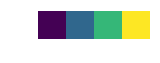

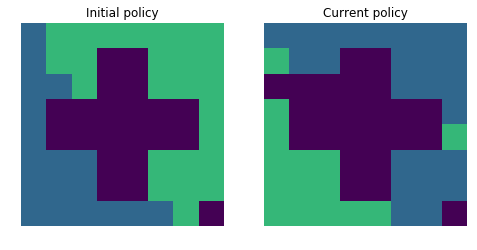

In [8]:

env = grid_world()                                                # Instance of the environment.
max_eps = 500                                                     # Max number of episodes to train.        
max_steps = 200                                                   # Max steps per episode.
exp_decay = 0.99                                                  # Decay rate for the exploration epsilon.
random = False                                                    # Flag to use random initial state.

dims = [2,20,4]                                                   # Dimensions of the neural network of the agent.
                                                                  # dims are given as: [input,layer1,layer2]
                                                                  # input = 2 due to the state representation: [x,y]
                                                                  # layer1 = 20 means we have 20 neurons in layer 1
                                                                  # layer2 = 4 means we have 4 neurons in the output
                                                                  #  layer, this is due to the computational trick.
    
agent = our_double_deep_Qlearning(dims,lr=0.01)                       # Creates a Double Deep Q-learning agent.

buffer = ReplayBuffer()                                           # Creates a Replay buffer.

policies = run_deep_double_Qlearning(env,agent,buffer,max_eps,max_steps,exp_decay,random) # Run the DDQL algorithm.

plot_policies_DQN(policies)                       # Display the initial and final policies of the agent.

### Test the agent

<IPython.core.display.Javascript object>


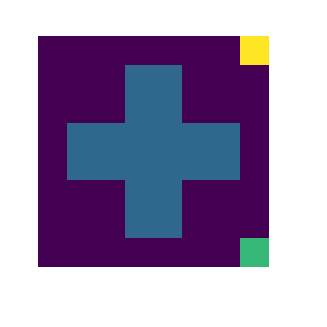

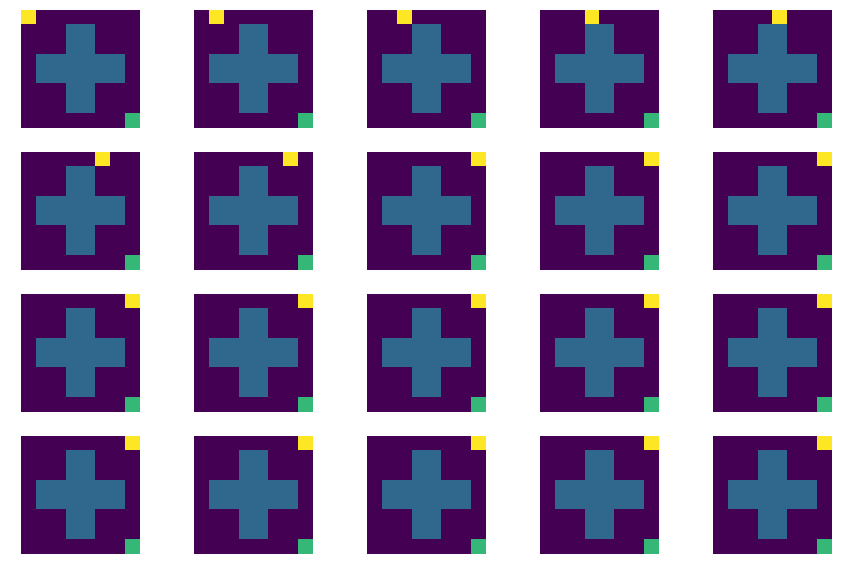

In [9]:
%matplotlib notebook

env = grid_world()                             # A new instance of the environment (required for rendering).

for episode in range(5):                       # Loop over some episodes.
    state = env.reset(random,True)             # Reset the environment.
    done = False                               # done flag starts as false.
    step = 1                                   # step counter starts in 1.
    
    trayectory = [env.get_map()]               # Python list to save trayectory.
    while (not done and step < 20):            # Looping until terminal or during max steps.
        action = agent.greedy(state)           # Select action based on greedy policy.
        state,_,done = env.step(action,True)   # Take selected action.
        step += 1                              # Increase step counter by one.
        env_map = env.render()                 # Render the environment.
        trayectory.append(env_map)             # Saves the current map in the trayectory.
        
%matplotlib inline

plot_trayectory(trayectory)                    # Plots trayectory of last episode

## Concluding remarks

* Double Deep Q-learning is able to generalize information. Hence, it is able to learn the good (even optimal) policies in large state-space environments.
* As we saw with experiments 3 and 4, more robust policies can be achieved with harder training scenarios that provide better generalization.
* Double Deep Q-learning requires more episodes to train because it is learning a function, not memorizing a table.